<a href="https://colab.research.google.com/github/Evil-Tux/Diffusion-Models/blob/main/Diffusion_Models_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion Models 101

In [1]:
!pip install diffusers==0.16.1 accelerate open_clip_torch transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage

from diffusers import DDPMScheduler, DDIMScheduler, DDPMPipeline, DDIMPipeline

from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np

def plot_images(images, n=8, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(10, 3))
    assert len(axs) == len(images)
    for i, img in enumerate(images):
        axs[i].axis('off')
        if isinstance(img, torch.Tensor):
            img = ToPILImage()((img/2+0.5).clamp(0, 1))
        axs[i].imshow(img.resize((64, 64), resample=Image.NEAREST), cmap='gray_r', vmin=0, vmax=255)

## The Power of Stable Diffusion

Behold the mighty stable diffusion model!

Open source and versatile, the stable diffusion model distinguishes itself from other image generation models by providing users access to its source code and the ability to train custom models.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/diffusion_model.png?raw=true)
Source: [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752)

The model has several moving parts, and it may look intimidating at first sight, but we'll take it apart, piece by piece, to make it more digestible.

But, before start dissecting this model, let's see what it is capable of with a short example.

The example below is a slightly modified version from a [notebook](https://github.com/huggingface/diffusion-models-class/blob/main/unit3/01_stable_diffusion_introduction.ipynb) in [Unit 3 of HuggingFace's Diffusion Models class](https://github.com/huggingface/diffusion-models-class/tree/main/unit3)

In [ ]:
import torch
from diffusers import DiffusionPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4").to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/35 [00:00<?, ?it/s]

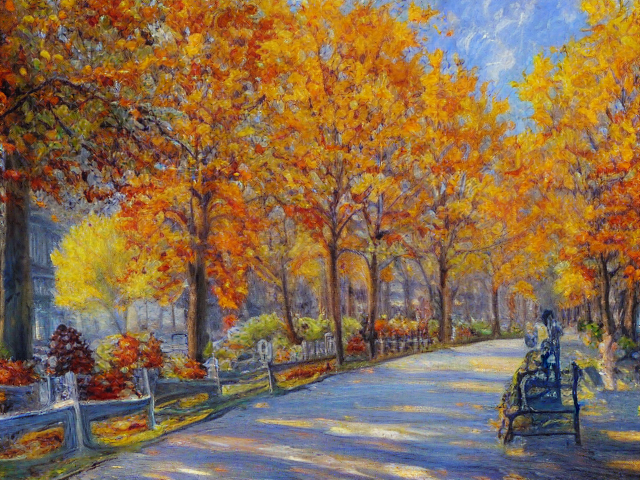

In [ ]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="impressionist painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image:
pipe_output.images[0]

Amazing, isn't it? Let's take a look at the several components that make up this pipeline:

In [ ]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


We **import** libraries and modules useful for diffusion models, such as PyTorch and Hugging Face’s diffusers. We'll be using the Modified National Institute of Standards and Technology (MNIST) dataset throughout the series. Once we have our imports and dataset, it’s time to use the model.
During training of diffusion models, **noise** transforms the image during generation. Essentially, the model begins with data, such as an image, and adds noise to it. During generation, the model uses a **scheduler** to gradually reduce the image’s noise to create a clear image. In the following sections, we’ll cover these concepts in more detail with examples.

## Dataset

Diffusion models can be large and training can be time consuming. For educational purposes, we will utilize a dataset comprising small images. This way, we can train and fine-tune models using Google Colab in a matter of minutes instead of hours, allowing us to experiment with diverse setups and configurations.

In the following example, we are utilizing the frequently used [MNIST dataset](https://www.digitalocean.com/community/tutorials/mnist-dataset-in-python), which stands for Modified National Institute of Standards and Technology.

Let’s resize the images from their original 28x28 pixels to 32x32 pixels and create tensors from them using Torchvision transforms directly within the dataset:


In [ ]:
composed = Compose([Resize(32), ToTensor()])
dataset = torchvision.datasets.MNIST(root="mnist/", train=True, download=True, transform=composed)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102993284.79it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22349759.01it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30022101.91it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20934647.00it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Let's use the `plot_images` helper function to visualize eight digits from the dataset:

In [ ]:
images = next(iter(train_dataloader))[0][:8]

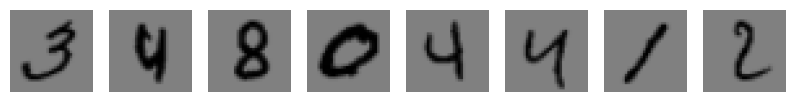

In [ ]:
plot_images(images)

Typical MNIST data, nothing new to see here, let's move on!

## Noise

Let's make some noise, literally! The snippet below generates eight images of pure [Gaussian noise](https://wiki.cloudfactory.com/docs/mp-wiki/augmentations/gaussian-noise):

In [ ]:
torch.manual_seed(13)
noise = torch.randn_like(images)
noise.shape

torch.Size([8, 1, 32, 32])

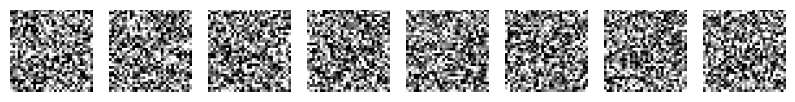

In [ ]:
plot_images(noise)

Believe it or not, diffusion models are able to transform images of pure Gaussian noise into real images, like the handwritten digits of MNIST above, or fancy artwork like the first example from HF's Stable Diffusion pipeline.

You can’t help but be amazed by the thought of this incredible transformation from noise to image - it's kind of like "discovering" images inside the noise!

Let's dig a bit deeper into this process. First, let's imagine that noise is incrementally added to an image (we'll start with a blank image for now) in 1,000 small steps. Every time we take a step, we get a little bit closer to pure Gaussian noise.

In [ ]:
steps = 1000
fractions = torch.linspace(0, steps-1, 5)/999
fractions

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

We can illustrate this process over a few selected steps: in the beginning, the image is blank, it gets progressively noisier, until it reaches the full level of noise we generated at the beginning. It's like the noise is "fading in"!

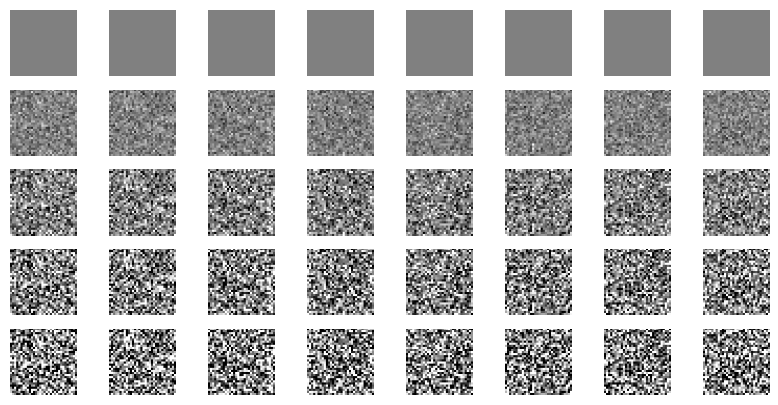

In [ ]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images(noise*f, axs=axs[i])

Now, let's do the exact opposite with the original MNIST images. We'll "fade out" the images over 1,000 steps. The images start as the original ones, and get progressively fainter, until they disappear completely into a blank image.

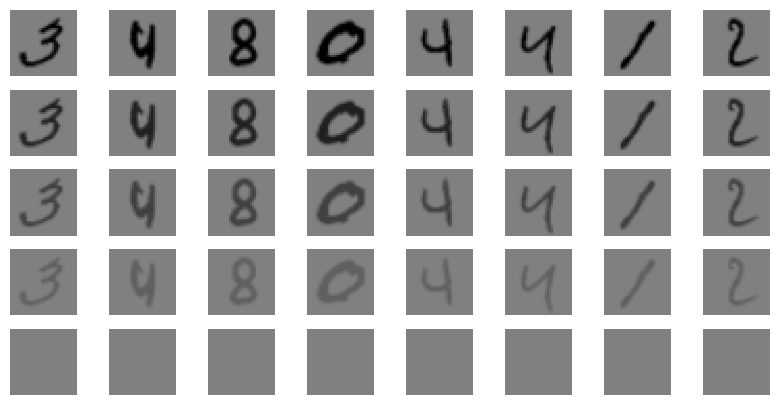

In [ ]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images((1-f)*images, axs=axs[i])

### Diffusion

Now, what happens if we add them up together, the progressively noisier images and fainter digits?

That's a simplified diffusion process!

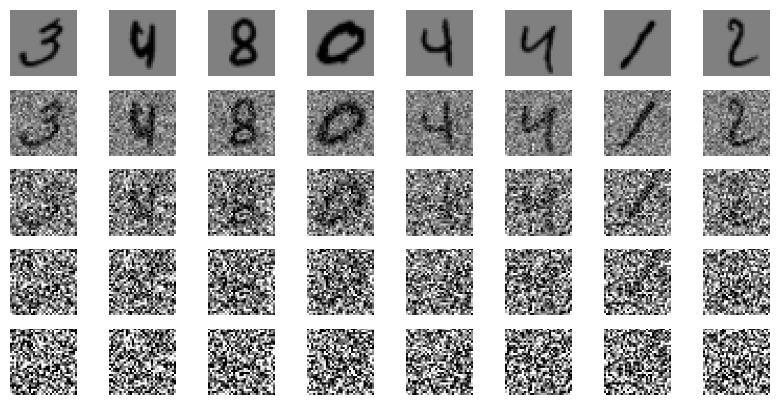

In [ ]:
fig, axs = plt.subplots(len(fractions), 8, figsize=(10, 5))
for i, f in enumerate(fractions):
    plot_images(noise*f+(1-f)*images, axs=axs[i])

There is more to this process than meets the eye, though. The diffusion does not have to follow a linear path, as demonstrated in the example above. There are different ways to weigh images and noise, and these are called **schedules**.

Unsurprisingly, the objects managing these schedules are called schedulers, marking the first component within the Stable Diffusion pipeline that we'll explore. These schedulers handle the intricate task of both adding and removing noise to and from images, shouldering the heavy lifting for us (more on this later).

### Scheduler

The image below, from the “Denoising Diffusion Probabilistic Models” paper by Jonathan Ho, Ajay Jain, and Pieter Abbeel, illustrates both processes:
- adding noise to a clean image, from right to left, using `q`
- removing noise from a noisy image, from left to right, using `p`

 Adding noise is relatively straightforward, thanks to some convenient mathematical properties that simplify determining the amount of noise to be added based on the current timestep. While we won’t delve into the details here, you can check Lilian Weng’s insightful blog post, [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for more specifics.

![](https://github.com/dvgodoy/DiffusionModels101_ODSC_Europe2023/blob/main/images/ddpm.png?raw=true)

Source: [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) by Jonathan Ho, Ajay Jain, Pieter Abbeel

The `diffusers` library from HuggingFace implements several schedulers, so we can leverage them to seamlessly add noise to our images. First, let's create a scheduler that uses 1,000 timesteps:

In [ ]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

Then, let's evenly divide the timesteps into eight parts:

In [ ]:
timesteps = torch.linspace(0, noise_scheduler.config.num_train_timesteps-1, 8).long()
timesteps

tensor([  0, 142, 285, 428, 570, 713, 856, 999])

Next, let's use the eight images we retrieved from our dataset and, for each image, add the noise corresponding to a given timestep using the aptly named `add_noise()` method.

It takes three arguments:
- clean images
- generated noise
- timesteps

In [ ]:
torch.manual_seed(13)
noise = torch.randn_like(images)

noisy_images = noise_scheduler.add_noise(images, noise, timesteps)

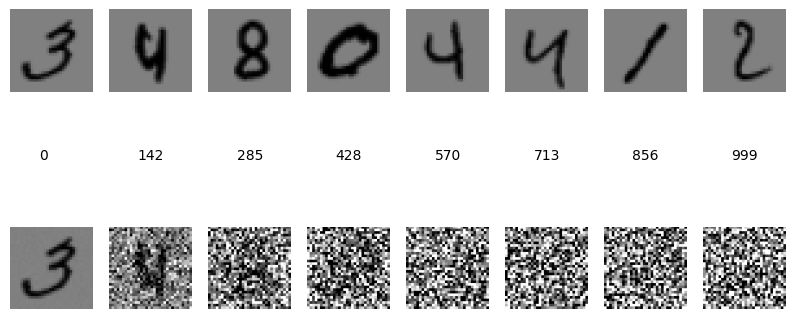

In [ ]:
fig, axs = plt.subplots(3, 8, figsize=(10, 4))
plot_images(images, axs=axs[0])
plot_images(noisy_images, axs=axs[2])
for i, ax in enumerate(axs[1]):
    ax.axis('off')
    ax.text(.35, .5, str(timesteps[i].item()))

As we progress from left to right, there's more and more noise added to the image. Additionally, it  appears that the transition from "clean" to "noisy" image happens more rapidly than in our previous example. Why is that the case? It’s because the "fading in" of the noise and the "fading out" of the original image do not follow a linear schedule.

Let’s go through *some* mathematical details after all to illustrate the process.

The expression below shows us how a given (noisy) image at timestep `t` is a composition of both the original image (`x0`) and pure Gaussian noise (`epsilon`):

$$
\Large
x_t = {\sqrt{\bar{\alpha}_t}} x_0 + \sqrt{(1 - \bar{\alpha}_t)} \epsilon
$$

They are weighted by coefficients based on the cumulative product of `alpha`. But what is this `alpha`? They are computed by the scheduler based on the defined schedule. Let's take a look at them:

In [ ]:
noise_scheduler.alphas

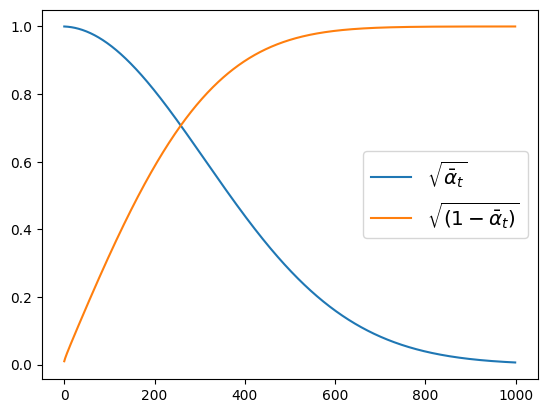

In [ ]:
plt.plot(noise_scheduler.alphas_cumprod ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large");

The original image (`x0`) is weighted by the blue line, while the yellow line drives the noise (`epsilon`). In the beginning (`t = 0`), there's only the original image. In the end (`t = 1000`), there's only noise. You may also notice that this schedule is quite different from the naive linear schedule we used to illustrate the diffusion process.

### Reverse Diffusion

That's where the magic, or better yet, the model, happens! A noisy image at a given timestep is the weighted sum of the original image and the noise:

$$
\Large
x_t = {\sqrt{\bar{\alpha}_t}} x_0 + \sqrt{(1 - \bar{\alpha}_t)} \epsilon
$$

In the diffusion process, we use two variables (the original image and the noise we create) to obtain a third variable (the noisy image).

In the reverse diffusion process, we have one variable (the noisy image) and we'd like to obtain another (the clean image)

$$
\Large
\hat{x_0} = \frac{\left( x_t - \sqrt{(1 - \bar{\alpha}_t)} \color{red}{\hat{\epsilon}} \right)}{\sqrt{\bar{\alpha}_t}}
$$

But we're still missing the third variable: the noise (in red). In order to generate a clean image, we need to know the noise, but how?

What if we build a model to predict the noise?

$$
\Large
\hat{x_0} = \frac{\left( x_t - \sqrt{(1 - \bar{\alpha}_t)} \color{red}{\text{model}(x, t)} \right)}{\sqrt{\bar{\alpha}_t}}
$$

Easy enough, right? Well, in theory, yes. In practice, the model won't be *that* good to predict the right amount of noise in one shot! So, it is actually done **incrementally**: we move one step at a time, from the noisy image towards the clean image using a weighted sum of the noisy image (`xt`) and the **predicted** clean image (`^x0`).

$$
\huge
\begin{array}
&x_{t-1} &=& c_0 &\hat{x_0} &+& c_1 &x_t
\\
& =& \frac{\sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)}{1-\bar{\alpha}_t}&\hat{x_0}&+&\frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t} &x_t
\end{array}
$$

Both coefficients are based on the alpha variable that drives the schedule, but we won't be going into any further details here.

#### Cheating

Now, let’s take a slight shortcut and construct a “model” that impeccably predicts the noise being added to the images. This approach is considered a bit of a cheat, as we use this “model” both as a noise generator AND a predictor!

First, we use it to generate some noise, and feed the noise to the scheduler.

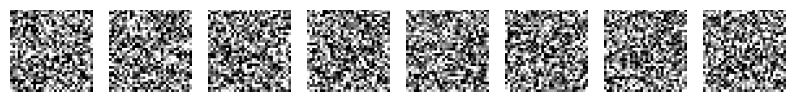

In [ ]:
def model(x, t):
    torch.manual_seed(13)
    noise = torch.randn_like(x)
    return noise

noise = model(images, None)
sample = noise_scheduler.add_noise(images, noise, torch.ones(8).long()*999)
plot_images(sample)

These are noisy MNIST images and they are unrecognizable.

Then, let's use our "model" to predict epsilon, and feed it to the scheduler's `step()` method, which also takes three arguments:
- predicted noise
- timesteps
- noisy images

After calling the `step` method, we can either retrieve the noisy image at the previous (`t-1`) step using the `prev_sample` attribute or the predicted original (clean) image using the `pred_original_sample` attribute.

We *know* our model is perfect, so let's take the predicted original sample right away:

In [ ]:
t = 999
epsilon = model(sample, t)
pred_x0 = noise_scheduler.step(epsilon, t, sample).pred_original_sample

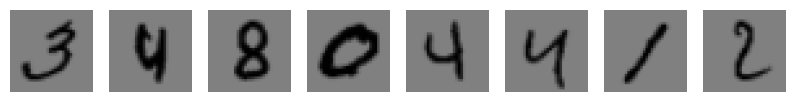

In [ ]:
plot_images(pred_x0)

Perfect digits! The noise was completely removed, as expected, since we're "cheating".

#### Less Noise in the Previous Step

Of course, perfect models do not exist. In reality, we would be iteratively generating better and better samples as we move backwards in time, using the (hopefully) less noisier sample predicted for `t-1` as input for the next step, until we reach `t = 0`.

In code, it looks like this:

In [ ]:
for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        epsilon = model(sample, t)

    sample = noise_scheduler.step(epsilon, t, sample).prev_sample

It is time for a real model now, and the typical model used with diffusion processes is the UNet model. In our next post in this series, we’ll explore the diffusers library UNet model class and break down examples showcasing the model’s efficiency.

We included a bonus section below, highlighting a few more impressive use cases of diffusion models. We will share content like this throughout the series, so be sure to check eviltux.com for more in-depth guides on diffusion models.

## Bonus

Generating images out of pure noise is incredible, but it is only the tip of the iceberg! Here we present several other amazing uses of the stable diffusion models.

### Image2Image

As the name says, it starts with an image, and turns it into another. You can think of it as giving the model a helping hand, so it doesn't have to start from pure noise.

The example below comes from a [fast.ai notebook on diffusion](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb): it takes a rough sketch of a wolf howling at the moon as starting point, and turns it into a really nice image.

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pipe = StableDiffusionImg2ImgPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)
pipe.to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


StableDiffusionImg2ImgPipeline {
  "_class_name": "StableDiffusionImg2ImgPipeline",
  "_diffusers_version": "0.16.1",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

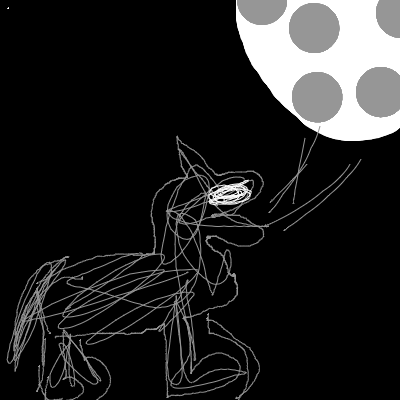

In [ ]:
import shutil
import requests

url = 'https://cdn-uploads.huggingface.co/production/uploads/1664665907257-noauth.png'
response = requests.get(url, stream=True)
with open('img.png', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

from PIL import Image
init_image = Image.open('img.png').convert("RGB")
init_image

In [ ]:
torch.manual_seed(1000)
prompt = "Wolf howling at the moon, photorealistic 4K"
images = pipe(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=0.8, num_inference_steps=50).images

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion_img2img.py:559: FutureWarning: You have passed 3 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/40 [00:00<?, ?it/s]

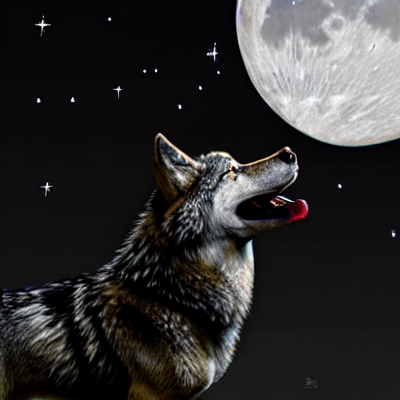

In [ ]:
init_image = images[2]
init_image

  0%|          | 0/70 [00:00<?, ?it/s]

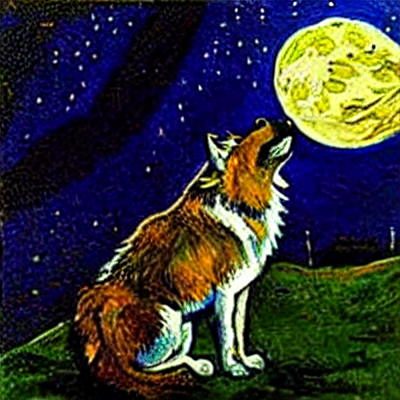

In [ ]:
torch.manual_seed(1000)
prompt = "Oil painting of wolf howling at the moon by Van Gogh"
new_images = pipe(prompt=prompt, num_images_per_prompt=3, image=init_image, strength=1, num_inference_steps=70).images
new_images[2]

### Textual Inversion

Textual inversion, proposed in the [An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion](https://textual-inversion.github.io/) paper and [repo](https://github.com/rinongal/textual_inversion), is a technique that allows you to consistently place yourself, or anything you want, in the generated images. How would you condition a model to generate images of you? Unless you're famous enough to be part of the training set used to train a CLIP model, chances are you're unknown to CLIP.

But, even if you don't want to place yourself, but your dog, the diffusion process will generate "a" dog, not "your" dog. The generated image may get the breed correct, but it is only a general depiction of the dog breed.

The underlying issue is that both you and your dog are unfamiliar to CLIP.. Textual inversion fixes that! How? It takes a specific, rarely used token (for whatever reason "sks" is a popular choice), and overfits it to a selection of images of yourself, or your dog. That way, CLIP gets to know you, and you can start calling yourself "sks" for the purpose of image generation.

You can also check HuggingFace's [textual inversion fine-tuning example](https://github.com/huggingface/diffusers/tree/main/examples/textual_inversion), but the example below comes from a [fast.ai notebook on diffusion](https://github.com/fastai/diffusion-nbs/blob/master/stable_diffusion.ipynb):

In [ ]:
pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)
pipe = pipe.to(device)

embeds_url = "https://huggingface.co/sd-concepts-library/indian-watercolor-portraits/resolve/main/learned_embeds.bin"
response = requests.get(embeds_url, stream=True)
with open('learned_embeds.bin', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

embeds_dict = torch.load('learned_embeds.bin', map_location=device)

unet/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [ ]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
new_token, embeds = next(iter(embeds_dict.items()))
embeds = embeds.to(text_encoder.dtype)
new_token

'<watercolor-portrait>'

In [ ]:
assert tokenizer.add_tokens(new_token) == 1, "The token already exists!"

In [ ]:
text_encoder.resize_token_embeddings(len(tokenizer))
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
text_encoder.get_input_embeddings().weight.data[new_token_id] = embeds

  0%|          | 0/50 [00:00<?, ?it/s]

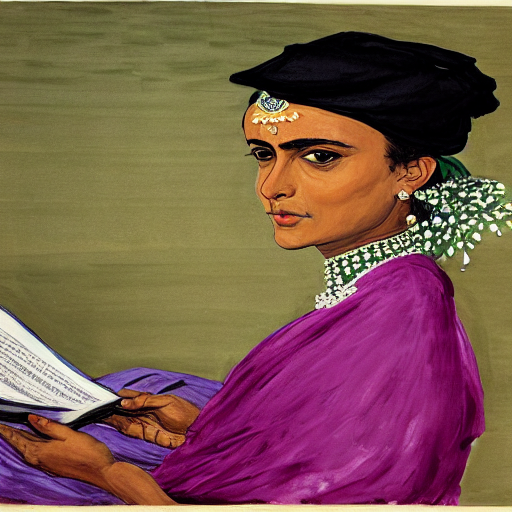

In [ ]:
torch.manual_seed(1000)
image = pipe("Woman reading in the style of <watercolor-portrait>").images[0]
image

### DreamBooth

DreamBooth is named after the idea of having a photobooth where you enter your dreams, placing yourself (or your dog) anywhere you want using image generation. It is the evolution of the textual inversion idea, but fine-tuning the whole model instead of only the textual embeddings. Before, you made CLIP know you, now, you'll make the whole stable diffusion pipeline aware of your existence :-)

Check the official [DreamBooth: Fine Tuning Text-to-Image Diffusion Models for Subject-Driven Generation](https://dreambooth.github.io/) for more details, and HuggingFace's [notebook from the Diffusers course](https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/hackathon/dreambooth.ipynb) for a working example.